# Evaluate artifical patients

## Load packages

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import importlib
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle
import numpy as np
import shap

from xgboost import XGBClassifier

# Import local package
from utils import waterfall
# Force package to be reloaded
importlib.reload(waterfall);


## Load synthetic data

In [2]:

synthetic = pd.read_csv('./synthetic/synthetic_10_features.csv')
synthetic.head()

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Stroke team,Use of AF anticoagulents,Onset-to-arrival time,Onset during sleep,Age
0,20,1,15,1,0,AGNOF1041H,0,80,0,72.5
1,20,1,15,1,0,AKCGO9726K,0,80,0,72.5
2,20,1,15,1,0,AOBTM3098N,0,80,0,72.5
3,20,1,15,1,0,APXEE8191H,0,80,0,72.5
4,20,1,15,1,0,ATDID5461S,0,80,0,72.5


One hot encode hopsitals:

In [3]:
# Keep copy of original, with 'Stroke team' not one-hot encoded
X = synthetic.copy(deep=True)

# One-hot encode 'Stroke team'
X_hosp = pd.get_dummies(X['Stroke team'], prefix = 'team')
X = pd.concat([X, X_hosp], axis=1)
X.drop('Stroke team', axis=1, inplace=True)

Amend data:

In [4]:
X['Stroke severity'] = 4

## Load pretrained models

In [5]:
# Load XGB Model
filename = (f'./synthetic/model.p')
with open(filename, 'rb') as filehandler:
    model = pickle.load(filehandler)

# Load SHAP explainers
filename = (f'./synthetic/shap_explainer.p')
with open(filename, 'rb') as filehandler:
        explainer = pickle.load(filehandler)
filename = (f'./synthetic/shap_explainer_probability.p')
with open(filename, 'rb') as filehandler:
        explainer_probability = pickle.load(filehandler)



In [6]:
stroke_team = synthetic['Stroke team']
probs = model.predict_proba(X)[:, 1]
results = pd.DataFrame()
results['Stroke team'] = stroke_team
results['Probability'] = probs
results['Thrombolyse'] = probs >= 0.5
results['Index'] = np.arange(len(results))
results.head()

,Stroke team,Probability,Thrombolyse,Index
0,AGNOF1041H,0.659291,True,0
1,AKCGO9726K,0.651429,True,1
2,AOBTM3098N,0.440186,False,2
3,APXEE8191H,0.659291,True,3
4,ATDID5461S,0.781318,True,4


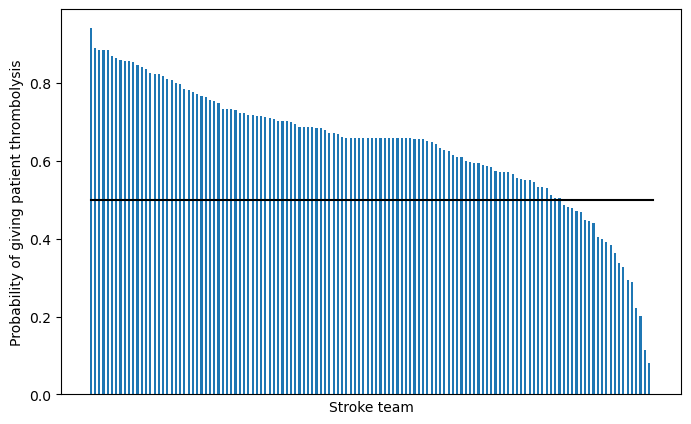

In [7]:
sorted_results = results.sort_values('Probability', ascending=False)

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()
x_chart = range(len(results))
ax.bar(x_chart, sorted_results['Probability'], width=0.5)
ax.plot([0, len(results)], [0.5, 0.5], c='k')
ax.axes.get_xaxis().set_ticks([])
ax.set_xlabel('Stroke team')
ax.set_ylabel('Probability of giving patient thrombolysis')
plt.show()



In [8]:
# Get index of highest probability team
index_high = sorted_results.iloc[0]['Index']
index_mid = sorted_results.iloc[int(len(sorted_results)/2)]['Index']
index_low = sorted_results.iloc[-1]['Index']

In [9]:
# Get Shapley values along with base and features
shap_values_probability_extended = explainer_probability(X)
# Shap values exist for each classification in a Tree
shap_values_probability = shap_values_probability_extended.values

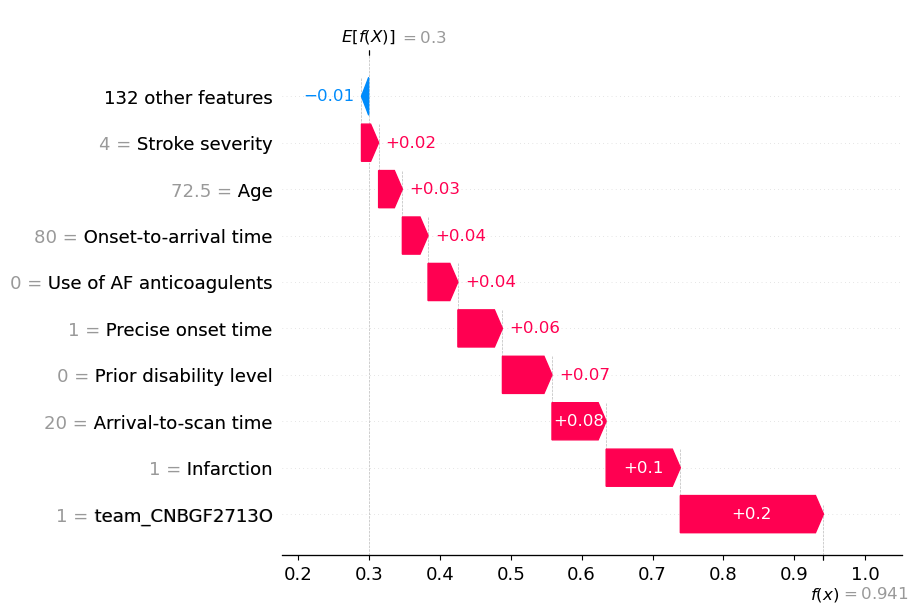

In [10]:
fig = waterfall.waterfall(
                shap_values_probability_extended[index_high],
                show=False, max_display=10, y_reverse=True)
plt.show()

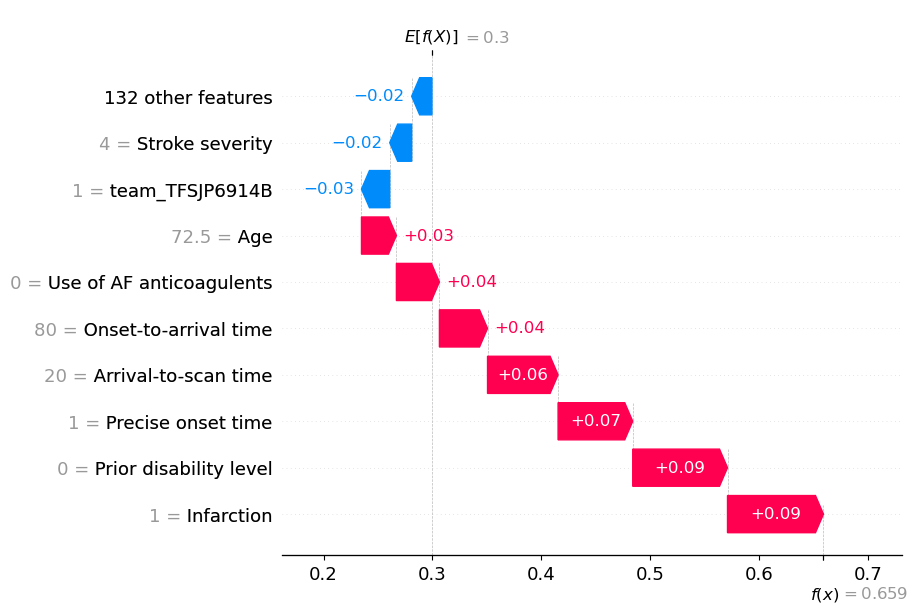

In [11]:
fig = waterfall.waterfall(
                shap_values_probability_extended[index_mid],
                show=False, max_display=10, y_reverse=True)
plt.show()

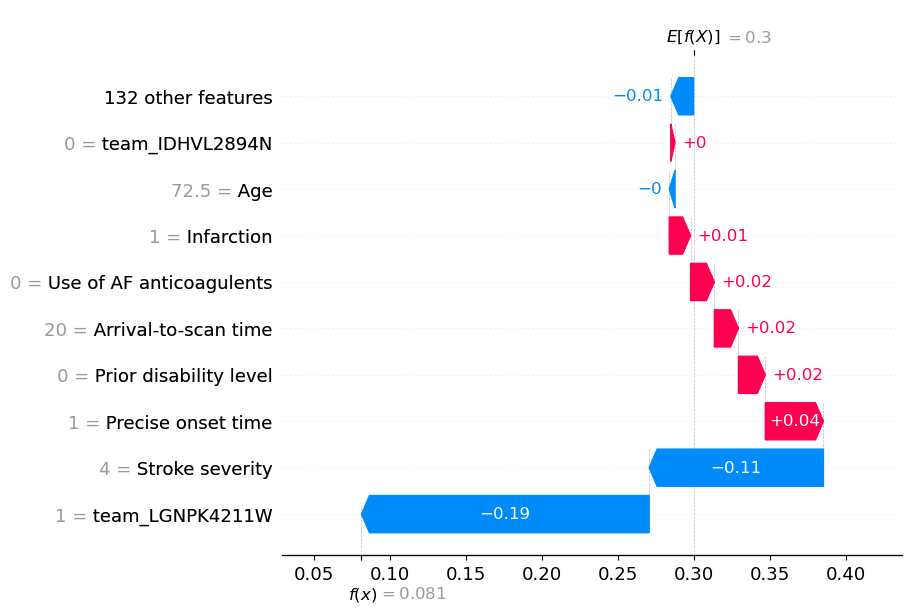

In [12]:
fig = waterfall.waterfall(
                shap_values_probability_extended[index_low],
                show=False, max_display=10, y_reverse=True)
plt.show()